On final dataset, using only labeled images ; Resnet18 -> Linear -> LeakyRelu -> Linear



In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

from torch.utils.data import Dataset
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from PIL import Image
import random
import cv2
import progressbar
import time
import os

In [3]:
df = pd.read_pickle("data/dataset.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8090 entries, 0 to 8089
Data columns (total 3 columns):
image      8090 non-null object
points     8090 non-null object
labeled    8090 non-null int64
dtypes: int64(1), object(2)
memory usage: 189.7+ KB


In [4]:
df.head()

,image,points,labeled
0,data/dactar/1300_img.png,"[177.16228095049055, 184.83182101741053, 244.7...",1
1,data/dactar/1766_img.png,"[409.7109787838158, 362.74050003943523, 536.55...",1
2,data/dactar/130_img.png,"[386.66894459252546, 342.1963080587535, 503.59...",1
3,data/dactar/1785_img.png,"[197.75577726950075, 171.98786970581278, 250.1...",1
4,data/dactar/617_img.png,"[180.14505945291972, 298.14972872833135, 288.5...",1


In [5]:
todrop = []
for i in range(len(df)):
  if df.iloc[i].labeled == 0:
    todrop.append(i)
df = df.drop(index=todrop)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5576 entries, 0 to 7440
Data columns (total 3 columns):
image      5576 non-null object
points     5576 non-null object
labeled    5576 non-null int64
dtypes: int64(1), object(2)
memory usage: 174.2+ KB


In [6]:
df = df.drop(columns=['labeled'])
df = df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5576 entries, 0 to 5575
Data columns (total 2 columns):
image     5576 non-null object
points    5576 non-null object
dtypes: object(2)
memory usage: 87.2+ KB


### Utilities

In [7]:
class AverageMeter(object):
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.cnt = 0
        
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.cnt += n
        self.avg = self.sum / self.cnt

### Image Transform

In [8]:
class ResizeAspect(object):
    def __init__(self, h, w):
        self.rescale_factor=None
        self.shift_w=None
        self.shift_h=None
        self.hw = (h, w)
        
    def do_image(self,img):
        h, w = self.hw
        img_h, img_w = img.shape[0], img.shape[1]
        rescale_factor = min(w/img_w, h/img_h)
        new_w = int(img_w * rescale_factor)
        new_h = int(img_h * rescale_factor)
        resized_image = cv2.resize(img, (new_w,new_h), interpolation = cv2.INTER_CUBIC)

        canvas = np.full((h, w, 3), 128, dtype=np.uint8)
        shift_h = (h-new_h)//2
        shift_w = (w-new_w)//2
        canvas[(h-new_h)//2:(h-new_h)//2 + new_h,(w-new_w)//2:(w-new_w)//2 + new_w,  :] = resized_image
        img = canvas.copy()
        self.rescale_factor=rescale_factor
        self.shift_h = shift_h
        self.shift_w = shift_w
        return img
    
    def do_box(self, box):
#         if self.rescale_factor is None:
#             print('The image is not scaled, do_image first!!')
#             return
        box = box.reshape(-1,2)
        box *=self.rescale_factor
        box[: ,0] += self.shift_w
        box[: ,1] += self.shift_h
        box = box.reshape(-1)
        return box
    
    def undo_box(self, box):
        box = box.reshape(-1,2)
        box[: ,0] -= self.shift_w
        box[: ,1] -= self.shift_h
        box /=self.rescale_factor
        box = box.reshape(-1)
        return box

In [9]:
class FinalTransform:
    def __init__(self):
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])
    
    def transform_inv(self,img):
        inp = img.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
        return inp

### Dataset Loader

In [10]:
class LicenseDataset(Dataset):
    def __init__(self, df):
        
        self.imgs = list(df.image)
        self.boxes = df.points.tolist()
#         self.labeled = df.labeled.tolist()
        self.final_transform = FinalTransform()
        self.transform = self.final_transform.transform
#         self.transform = transforms.Compose([
# #                 transforms.Resize((224, 224)),
#             transforms.ToTensor(),
#             transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                  std=[0.229, 0.224, 0.225])
#         ])
        
    def transform_inv(self,img):
        inp = img.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
        return inp
            
    def __getitem__(self, index):
        path= self.imgs[index]
        box = self.boxes[index]
        
        img = Image.open(path).convert('RGB')
        resizer = ResizeAspect(h=224, w=224)
        img = resizer.do_image(np.array(img))
        img = self.final_transform.transform(img)
        box = resizer.do_box(box)
        box = np.array(box, dtype=np.float32)
        
#         return img, box , resizer
        return img, box
      
    
    def __len__(self):
        return len(self.imgs)

In [11]:
def train_test_split(df, test_size=0.1):
    if isinstance(test_size, float):
        test_size = int(test_size * len(df))

    indices = df.index.tolist()
    test_indices = random.sample(population=indices, k=test_size)

    test_df = df.loc[test_indices]
    train_df = df.drop(test_indices)
    return train_df, test_df

In [12]:
train_df, test_df = train_test_split(df, test_size=0.1)

In [13]:
train = LicenseDataset(train_df)
test = LicenseDataset(test_df)

In [14]:
# ind = random.choice(range(len(train_df)))
# img, box, img_size = train[ind]

# box = np.append(box, box[:2]).reshape(-1,2)
# img = train.final_transform.transform_inv(img)

# plt.imshow(img)
# plt.plot(box[:,0], box[:,1], lw=3, c='g')

In [15]:
train_loader = torch.utils.data.DataLoader(
                train, batch_size=32,shuffle=True,
                num_workers=4, pin_memory=True)
test_loader = torch.utils.data.DataLoader(
                test, batch_size=32,shuffle=False,
                num_workers=2, pin_memory=True)

### Defining Model

In [0]:
model = models.resnet18(pretrained=True)
'''
output of our model is :
x1, y1,
x2, y2,
x3, y3,
x4, y4,
conf -> only when no bounding box images are taken
'''
num_feature = model.fc.in_features
num_hidden = 370
num_output = 8#9
model.fc = nn.Sequential(nn.Linear(num_feature, num_hidden),
                         nn.LeakyReLU(),
                         nn.Linear(num_hidden, num_output)
                        )
# model.fc = nn.Linear(num_feature, num_output)
# model.eval()
# model.train()
model = model.cuda()

In [0]:
MPATH = 'saved_states/model_state_v1.pth'
# model.load_state_dict(torch.load(MPATH))

In [0]:
criterion = nn.SmoothL1Loss().cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [0]:
best_model_state = model.state_dict()
best_epoch = -1
best_acc = 0.0

epoch_loss = {True: [], False: []}
epoch_acc = {True: [], False: []}
epochs = 20

In [0]:
for epoch in range(epochs):
    accs = AverageMeter()
    losses = AverageMeter()
    for train_mode in (True, False):
        if train_mode:
            scheduler.step()
            data_loader = train_loader
        else:
            data_loader = test_loader
        model.train(mode=train_mode)
            
        end = time.time()
        bar = progressbar.ProgressBar()
        for ims, boxes in bar(data_loader):
            
            inputs = ims.cuda()
            targets = boxes.cuda()
            
            optimizer.zero_grad()
            
            # forward
            outputs = model(inputs)
            loss = criterion(outputs, targets)
#             acc = compute_acc(outputs.data.cpu(), targets.data.cpu(), im_sizes)
            
            nsample = inputs.size(0)
#             accs.update(acc, nsample)
            losses.update(loss.data, nsample)
            
            if train_mode:
                loss.backward()
                optimizer.step()
        
#         if not train_mode and accs.avg > best_acc:
#             best_acc = accs.avg
#             best_epoch = epoch
#             best_model_state = model.state_dict()
            
        elapsed_time = time.time() - end
        print('[{}]\tEpoch: {}/{}\tLoss: {:.4f}\tAcc: {:.2%}\tTime: {:.3f}'.format(
            train_mode, epoch+1, epochs, losses.avg, accs.avg, elapsed_time))
        epoch_loss[train_mode].append(losses.avg)
        epoch_acc[train_mode].append(accs.avg)
        
    print('[Info] best test acc: {:.2%} at {}th epoch'.format(best_acc, best_epoch))
    torch.save(model.state_dict(), MPATH)

100% (157 of 157) |######################| Elapsed Time: 0:03:00 Time:  0:03:00


[True]	Epoch: 1/20	Loss: 12.1433	Acc: 0.00%	Time: 184.635


100% (18 of 18) |########################| Elapsed Time: 0:00:42 Time:  0:00:42


[False]	Epoch: 1/20	Loss: 11.9437	Acc: 0.00%	Time: 48.262
[Info] best test acc: 0.00% at -1th epoch


100% (157 of 157) |######################| Elapsed Time: 0:01:02 Time:  0:01:02


[True]	Epoch: 2/20	Loss: 8.9632	Acc: 0.00%	Time: 63.814


100% (18 of 18) |########################| Elapsed Time: 0:00:06 Time:  0:00:06


[False]	Epoch: 2/20	Loss: 8.5710	Acc: 0.00%	Time: 6.921
[Info] best test acc: 0.00% at -1th epoch


100% (157 of 157) |######################| Elapsed Time: 0:01:00 Time:  0:01:00


[True]	Epoch: 3/20	Loss: 5.3099	Acc: 0.00%	Time: 62.366


100% (18 of 18) |########################| Elapsed Time: 0:00:05 Time:  0:00:05


[False]	Epoch: 3/20	Loss: 5.3647	Acc: 0.00%	Time: 6.739
[Info] best test acc: 0.00% at -1th epoch


100% (157 of 157) |######################| Elapsed Time: 0:01:01 Time:  0:01:01


[True]	Epoch: 4/20	Loss: 4.1719	Acc: 0.00%	Time: 62.958


100% (18 of 18) |########################| Elapsed Time: 0:00:06 Time:  0:00:06


[False]	Epoch: 4/20	Loss: 4.0917	Acc: 0.00%	Time: 6.957
[Info] best test acc: 0.00% at -1th epoch


100% (157 of 157) |######################| Elapsed Time: 0:01:01 Time:  0:01:01


[True]	Epoch: 5/20	Loss: 3.9659	Acc: 0.00%	Time: 63.686


100% (18 of 18) |########################| Elapsed Time: 0:00:06 Time:  0:00:06


[False]	Epoch: 5/20	Loss: 3.9185	Acc: 0.00%	Time: 7.051
[Info] best test acc: 0.00% at -1th epoch


100% (157 of 157) |######################| Elapsed Time: 0:01:03 Time:  0:01:03


[True]	Epoch: 6/20	Loss: 4.0040	Acc: 0.00%	Time: 65.332


100% (18 of 18) |########################| Elapsed Time: 0:00:06 Time:  0:00:06


[False]	Epoch: 6/20	Loss: 3.9394	Acc: 0.00%	Time: 7.120
[Info] best test acc: 0.00% at -1th epoch


100% (157 of 157) |######################| Elapsed Time: 0:01:03 Time:  0:01:03


[True]	Epoch: 7/20	Loss: 3.7059	Acc: 0.00%	Time: 64.855


100% (18 of 18) |########################| Elapsed Time: 0:00:06 Time:  0:00:06


[False]	Epoch: 7/20	Loss: 3.6640	Acc: 0.00%	Time: 7.063
[Info] best test acc: 0.00% at -1th epoch


100% (157 of 157) |######################| Elapsed Time: 0:01:02 Time:  0:01:02


[True]	Epoch: 8/20	Loss: 3.5729	Acc: 0.00%	Time: 64.027


100% (18 of 18) |########################| Elapsed Time: 0:00:06 Time:  0:00:06


[False]	Epoch: 8/20	Loss: 3.5440	Acc: 0.00%	Time: 7.081
[Info] best test acc: 0.00% at -1th epoch


100% (157 of 157) |######################| Elapsed Time: 0:01:02 Time:  0:01:02


[True]	Epoch: 9/20	Loss: 3.3037	Acc: 0.00%	Time: 64.136


100% (18 of 18) |########################| Elapsed Time: 0:00:06 Time:  0:00:06


[False]	Epoch: 9/20	Loss: 3.2543	Acc: 0.00%	Time: 7.003
[Info] best test acc: 0.00% at -1th epoch


100% (157 of 157) |######################| Elapsed Time: 0:01:02 Time:  0:01:02


[True]	Epoch: 10/20	Loss: 3.2550	Acc: 0.00%	Time: 64.735


100% (18 of 18) |########################| Elapsed Time: 0:00:06 Time:  0:00:06


[False]	Epoch: 10/20	Loss: 3.2027	Acc: 0.00%	Time: 6.940
[Info] best test acc: 0.00% at -1th epoch


100% (157 of 157) |######################| Elapsed Time: 0:01:02 Time:  0:01:02


[True]	Epoch: 11/20	Loss: 3.1531	Acc: 0.00%	Time: 63.566


100% (18 of 18) |########################| Elapsed Time: 0:00:06 Time:  0:00:06


[False]	Epoch: 11/20	Loss: 3.1052	Acc: 0.00%	Time: 7.194
[Info] best test acc: 0.00% at -1th epoch


100% (157 of 157) |######################| Elapsed Time: 0:01:04 Time:  0:01:04


[True]	Epoch: 12/20	Loss: 3.1115	Acc: 0.00%	Time: 65.764


100% (18 of 18) |########################| Elapsed Time: 0:00:06 Time:  0:00:06


[False]	Epoch: 12/20	Loss: 3.0616	Acc: 0.00%	Time: 6.933
[Info] best test acc: 0.00% at -1th epoch


100% (157 of 157) |######################| Elapsed Time: 0:01:02 Time:  0:01:02


[True]	Epoch: 13/20	Loss: 3.0893	Acc: 0.00%	Time: 63.847


100% (18 of 18) |########################| Elapsed Time: 0:00:06 Time:  0:00:06


[False]	Epoch: 13/20	Loss: 3.0323	Acc: 0.00%	Time: 6.986
[Info] best test acc: 0.00% at -1th epoch


100% (157 of 157) |######################| Elapsed Time: 0:01:02 Time:  0:01:02


[True]	Epoch: 14/20	Loss: 3.0691	Acc: 0.00%	Time: 64.430


100% (18 of 18) |########################| Elapsed Time: 0:00:05 Time:  0:00:05


[False]	Epoch: 14/20	Loss: 3.0253	Acc: 0.00%	Time: 6.564
[Info] best test acc: 0.00% at -1th epoch


100% (157 of 157) |######################| Elapsed Time: 0:00:59 Time:  0:00:59


[True]	Epoch: 15/20	Loss: 3.0126	Acc: 0.00%	Time: 61.318


100% (18 of 18) |########################| Elapsed Time: 0:00:06 Time:  0:00:06


[False]	Epoch: 15/20	Loss: 2.9631	Acc: 0.00%	Time: 6.814
[Info] best test acc: 0.00% at -1th epoch


100% (157 of 157) |######################| Elapsed Time: 0:01:02 Time:  0:01:02


[True]	Epoch: 16/20	Loss: 2.8875	Acc: 0.00%	Time: 63.746


100% (18 of 18) |########################| Elapsed Time: 0:00:06 Time:  0:00:06


[False]	Epoch: 16/20	Loss: 2.8499	Acc: 0.00%	Time: 7.022
[Info] best test acc: 0.00% at -1th epoch


100% (157 of 157) |######################| Elapsed Time: 0:00:59 Time:  0:00:59


[True]	Epoch: 17/20	Loss: 2.9613	Acc: 0.00%	Time: 60.957


100% (18 of 18) |########################| Elapsed Time: 0:00:05 Time:  0:00:05


[False]	Epoch: 17/20	Loss: 2.9138	Acc: 0.00%	Time: 6.729
[Info] best test acc: 0.00% at -1th epoch


100% (157 of 157) |######################| Elapsed Time: 0:00:59 Time:  0:00:59


[True]	Epoch: 18/20	Loss: 2.8708	Acc: 0.00%	Time: 61.197


100% (18 of 18) |########################| Elapsed Time: 0:00:06 Time:  0:00:06


[False]	Epoch: 18/20	Loss: 2.8321	Acc: 0.00%	Time: 7.323
[Info] best test acc: 0.00% at -1th epoch


100% (157 of 157) |######################| Elapsed Time: 0:00:59 Time:  0:00:59


[True]	Epoch: 19/20	Loss: 2.9453	Acc: 0.00%	Time: 61.115


100% (18 of 18) |########################| Elapsed Time: 0:00:06 Time:  0:00:06


[False]	Epoch: 19/20	Loss: 2.9103	Acc: 0.00%	Time: 6.880
[Info] best test acc: 0.00% at -1th epoch


100% (157 of 157) |######################| Elapsed Time: 0:00:58 Time:  0:00:58


[True]	Epoch: 20/20	Loss: 2.9569	Acc: 0.00%	Time: 60.280


100% (18 of 18) |########################| Elapsed Time: 0:00:06 Time:  0:00:06


[False]	Epoch: 20/20	Loss: 2.9286	Acc: 0.00%	Time: 6.974
[Info] best test acc: 0.00% at -1th epoch


In [0]:
test_batch = 0
indx = -1
model.eval()
print('Working in test mode')

Working in test mode


4


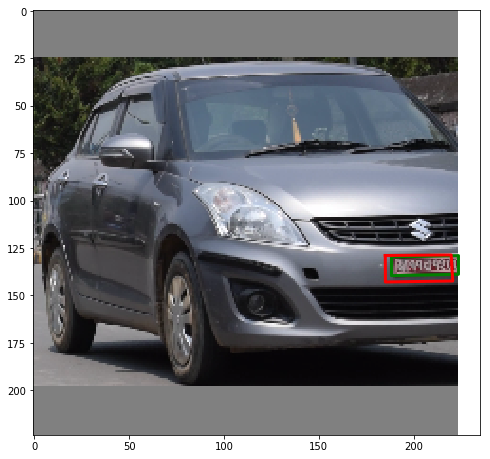

In [0]:
if indx < 0:
  # model.train(mode=False)
  for i,(ims, boxes) in enumerate(test_loader):
    if i<test_batch:
      continue
    inputs = ims.cuda()
    targets = boxes.cuda()
    outputs = model(inputs)
    test_batch +=1
    break
    
indx +=1
img = inputs[indx].data.cpu()
img = FinalTransform().transform_inv(img)
out = outputs[indx].data.cpu().numpy()
out = np.append(out, out[:2]).reshape(-1,2)
targ = targets[indx].data.cpu().numpy()
targ = np.append(targ, targ[:2]).reshape(-1,2)


plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.plot(targ[:,0], targ[:,1], lw=3, c='g')
plt.plot(out[:,0], out[:,1], lw=3, c='r')
print(indx)
if indx == 31:
  indx = -1

In [0]:
# i+=1
# img = inputs[i].data.cpu()
# img = FinalTransform().transform_inv(img)
# out = outputs[i].data.cpu().numpy()
# out = np.append(out, out[:2]).reshape(-1,2)

# plt.figure(figsize=(8, 8))
# plt.imshow(img)
# plt.plot(out[:,0], out[:,1], lw=3, c='g')
# i

In [0]:
model_state = model.state_dict()
torch.save(model_state, MPATH)
# optimizer_state = optimizer.state_dict()
# torch.save(optimizer_state, 'optimizer_state_v1.pth')